In [1]:
include("src/Sim.jl")

Main.Sim

In [2]:
using DifferentialEquations
using Plots
using .Sim

In [3]:
@model Decoder begin
    @parameter alpha_A alpha_T alpha_i V_A_min
    
    @blk In1 = InBlock()
    @blk In2 = InBlock()
    @blk Gain = GainBlock(1/alpha_T)
    @blk Gain1 = GainBlock(1/alpha_i)
    @blk Gain2 = GainBlock(1/alpha_A)
    @blk Gain3 = GainBlock(1/alpha_A)
    @blk Constant = ConstantBlock(V_A_min)
    @blk Constant1 = ConstantBlock(V_A_min)
    @blk Out1 = OutBlock()
    @blk Out2 = OutBlock()
    
    @connect In1 => Gain2
    @connect Gain2 + Constant => Gain
    @connect Gain => Out1
    @connect In2 => Gain3
    @connect Gain3 + Constant1 => Gain1
    @connect Gain1 => Out2
end

Decoder (generic function with 1 method)

In [59]:
@model Encoder begin
    @parameter m u_max u_min
    
    @blk In = InBlock()
    @blk Constant = ConstantBlock(u_min)
    @blk Gain = GainBlock((2^m-1)/(u_max-u_min))
    @blk Out = OutBlock()
    
    @connect In +　Constant => Gain
    @connect Gain => Out
end

Encoder (generic function with 1 method)

In [69]:
@model algorithm begin
    @parameter n alpha_T alpha_i V_A_max V_A_min m u_max u_min d_N_d d_i_d
    
    @blk Pulse = PulseGeneratorBlock(amplitude=100, period=30, pulsewidth=50, phasedelay=0) outport:u
    @blk Ramp = RampBlock(slope=d_N_d, starttime=0, initialoutput=0) outport:d_N
    @blk Ramp1 = RampBlock(slope=d_i_d, starttime=0, initialoutput=0) outport:d_i
    @blk encoder = Encoder(m=m, u_max=u_max, u_min=u_min) outport:d_P
    @blk decoder = Decoder(alpha_A=((2^(n)-1)/(V_A_max-V_A_min)), alpha_T=alpha_T, alpha_i=alpha_i, V_A_min=V_A_min) inport[1]:in1 inport[2]:in2 outport[1]:N_ outport[2]:i_
    
    @connect u => encoder
    @connect d_N => in1
    @connect d_i => in2
end

algorithm (generic function with 1 method)

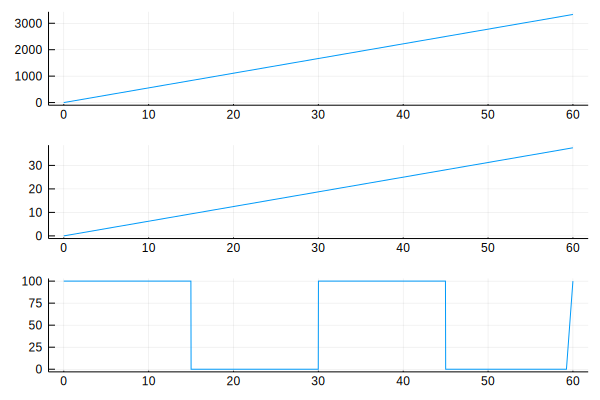

In [70]:
m1 = algorithm(n=10, alpha_T=1.5/1000, alpha_i=5/37.5, V_A_max=5, V_A_min=0, m=10, u_max=100, u_min=0, d_N_d=(2^(10)-1)/60, d_i_d=(2^(10)-1)/60)
sol = @simulate(m1, tspan = (0.0, 60.0), scope=[N_, i_, u])
sol.graph

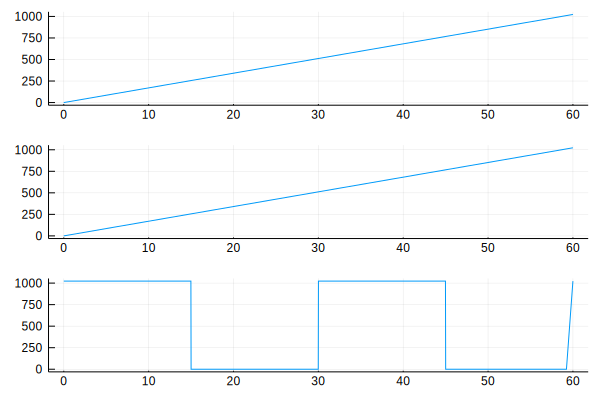

In [71]:
sol = @simulate(m1, tspan = (0.0, 60.0), scope=[d_N, d_i, d_P])
sol.graph

In [8]:
@model Controller begin
    @parameter n alpha_T alpha_i V_A_max V_A_min m u_max u_min
    
    @blk In1 = InBlock()
    @blk In2 = InBlock()
    @blk Pulse = PulseGeneratorBlock(amplitude=100, period=30, pulsewidth=50, phasedelay=0) outport:u
    @blk encoder = Encoder(m=m, u_max=u_max, u_min=u_min) outport:d_P
    @blk decoder = Decoder(alpha_A=((2^(n)-1)/(V_A_max-V_A_min)), alpha_T=alpha_T, alpha_i=alpha_i, V_A_min=V_A_min) inport[1]:in1 inport[2]:in2 outport[1]:N_ outport[2]:i_
    @blk Out = OutBlock()
    
    @connect u => encoder
    @connect In1 => in1
    @connect In2 => in2
    @connect d_P => Out

end

Controller (generic function with 1 method)

In [9]:
@model testController begin
    @parameter n alpha_T alpha_i V_A_max V_A_min m u_max u_min d_N_d d_i_d
    
    @blk Ramp = RampBlock(slope=d_N_d, starttime=0, initialoutput=0) outport:d_N
    @blk Ramp1 = RampBlock(slope=d_i_d, starttime=0, initialoutput=0) outport:d_i
    @blk cont = Controller(n=n, alpha_T=alpha_T, alpha_i=alpha_i, V_A_max=V_A_max, V_A_min=V_A_min, m=m, u_max=u_max, u_min=u_min) inport[1]:in1 inport[2]:in2 outport:d_P
    
    @connect d_N => in1
    @connect d_i => in2
end

testController (generic function with 1 method)

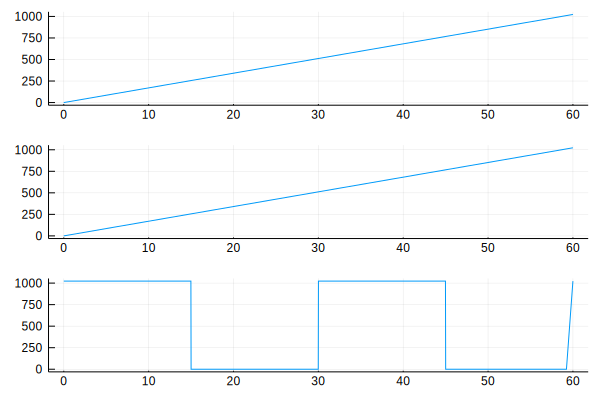

In [10]:
m = testController(n=10, alpha_T=1.5/1000, alpha_i=5/37.5, V_A_max=5, V_A_min=0, m=10, u_max=100, u_min=0, d_N_d=(2^(10)-1)/60, d_i_d=(2^(10)-1)/60)
sol = @simulate(m, tspan = (0.0, 60.0), scope=[d_N, d_i, d_P])
sol.graph

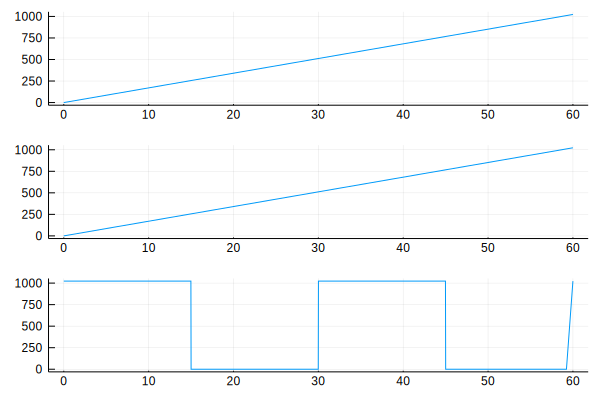

In [11]:
sol = @simulate(m1, tspan = (0.0, 60.0), scope=[d_N, d_i, d_P])
sol.graph

In [12]:
@model ADConverter begin
    @parameter V_A_min V_A_max alpha_A
    
    @blk In = InBlock()
    @blk Saturation = SaturationBlock(upperlimit=V_A_max, lowerlimit=V_A_min)
    @blk Constant = ConstantBlock(V_A_min)
    @blk Gain = GainBlock(alpha_A)
    @blk Quantizer = QuantizerBlock(quantizationinterval=1)
    @blk Out = OutBlock()
    
    @connect In => Saturation
    @connect Saturation - Constant => Gain
    @connect Gain => Quantizer
    @connect Quantizer => Out
end

ADConverter (generic function with 1 method)

In [13]:
@model PulseGenerator begin
    @parameter m alpha_P
    
    @blk In = InBlock()
    @blk Quantizer = QuantizerBlock(quantizationinterval=1)
    @blk Constant = ConstantBlock(2^m)
    @blk Mod = ModBlock() inport[1]:in1 inport[2]:in2
    @blk Gain = GainBlock(alpha_P)
    @blk Out = OutBlock()
    
    @connect In => Quantizer
    @connect Quantizer  => in1
    @connect Constant => in2
    @connect Mod => Gain
    @connect Gain => Out
end

PulseGenerator (generic function with 1 method)

In [14]:
@model ControllerModel begin
    @parameter V_A_min V_A_max n m
    
    @blk In1 = InBlock()
    @blk In2 = InBlock()
    @blk ADCon = ADConverter(V_A_min=V_A_min, V_A_max=V_A_max, alpha_A=(2^(n)-1)/(V_A_max-V_A_min)) outport:d_N
    @blk ADCon1 = ADConverter(V_A_min=V_A_min, V_A_max=V_A_max, alpha_A=(2^(n)-1)/(V_A_max-V_A_min)) outport:d_i
    @blk Cont = Controller(n=n, alpha_T=1.5/1000, alpha_i=5/37.5, V_A_max=5, V_A_min=0, m=10, u_max=100, u_min=0) inport[1]:in1 inport[2]:in2 outport:d_P
    @blk Pulse = PulseGenerator(m=m, alpha_P=100/(2^m-1)) outport:u_P
    @blk Out = OutBlock()
    
    @connect In1 => ADCon
    @connect In2 => ADCon1
    @connect d_N => in1
    @connect d_i => in2
    @connect d_P => Pulse
    @connect u_P => Out
end

ControllerModel (generic function with 1 method)

In [17]:
@model ControllerModelTest begin
    @parameter V_A_min V_A_max n m
    @parameter v_N_d v_i_d
    
    @blk Ramp = RampBlock(slope=v_N_d, starttime=0, initialoutput=0) outport:v_N
    @blk Ramp1 = RampBlock(slope=v_i_d, starttime=0, initialoutput=0) outport:v_i
    @blk CM = ControllerModel(V_A_min=V_A_min, V_A_max=V_A_max, n=n, m=m) inport[1]:in1 inport[2]:in2 outport:u_P
    
    @connect v_N => in1
    @connect v_i => in2
end

ControllerModelTest (generic function with 1 method)

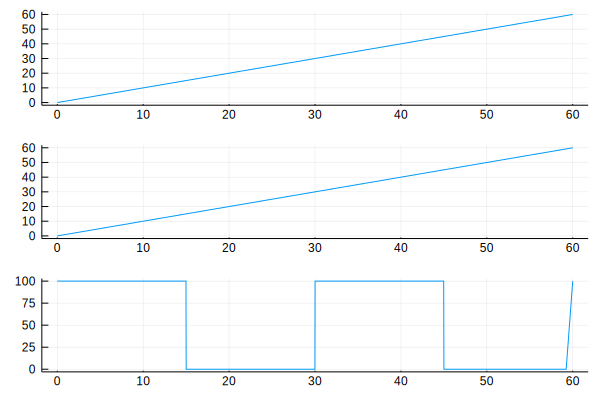

In [20]:
m = ControllerModelTest(V_A_min=0, V_A_max=5, n=10, m=8, v_N_d=1, v_i_d=1)
sol = @simulate(m, tspan = (0.0, 60.0), scope=[v_N, v_i, u_P])
sol.graph

In [46]:
@model MotorDriver begin
    @parameter alpha_i
    
    @blk In1 = InBlock()
    @blk In2 = InBlock()
    @blk In3 = InBlock()
    @blk Gain = GainBlock(1/100)
    @blk Gain1 = GainBlock(alpha_i)
    @blk Out1 = OutBlock()
    @blk Out2 = OutBlock()
    
    @connect In2 => Gain
    @connect In1 * Gain => Out1
    @connect In3 => Gain1
    @connect Gain1 => Out2
end

MotorDriver (generic function with 1 method)

In [47]:
@model DCMotorDisk begin
    @parameter L K_tau J_M J_I D K_e R
    
    @blk In = InBlock()
    @blk Gain = GainBlock(1/L)
    @blk Integrator = IntegratorBlock(initialcondition=0)
    @blk Gain1 = GainBlock(K_tau)
    @blk Gain2 = GainBlock(1/(J_M+J_I))
    @blk Integrator1 = IntegratorBlock(initialcondition=0)
    @blk Gain3 = GainBlock(D)
    @blk Gain4 = GainBlock(K_e)
    @blk Gain5 = GainBlock(R)
    @blk Out1 = OutBlock()
    @blk Out2 = OutBlock()
    
    @connect In - Gain4 - Gain5 => Gain
    @connect Gain => Integrator
    @connect Integrator => Gain1
    @connect Gain1 - Gain3 => Gain2
    @connect Gain2 => Integrator1
    @connect Integrator1 => Gain3
    @connect Integrator1 => Gain4
    @connect Integrator => Gain5
    @connect Integrator1 => Out1
    @connect Integrator => Out2
end

DCMotorDisk (generic function with 1 method)

In [48]:
@model Tachogenerator begin
    @parameter alpha_T
    
    @blk In = InBlock()
    @blk Gain = GainBlock(60/(2*pi))
    @blk Gain1 = GainBlock(alpha_T)
    @blk Out = OutBlock()
    
    @connect In => Gain
    @connect Gain => Gain1
    @connect Gain1 => Out
end

Tachogenerator (generic function with 1 method)

In [49]:
@model PlantModel begin
    @parameter Vs
    @parameter alpha_i
    @parameter L K_tau J_M J_I D K_e R
    @parameter alpha_T
    
    @blk In = InBlock()
    @blk Constant = ConstantBlock(Vs)
    @blk MD = MotorDriver(alpha_i=alpha_i) inport[1]:in1 inport[2]:in2 inport[3]:in3 outport[1]:v_A outport[2]:v_i
    @blk DCMD = DCMotorDisk(L=L, K_tau=K_tau, J_M=J_M, J_I=J_I, D=D, K_e=K_e, R=R) outport[1]:omega outport[2]:i_M
    @blk T = Tachogenerator(alpha_T=alpha_T) outport:v_N
    @blk Out1 = OutBlock()
    @blk Out2 = OutBlock()
    
    @connect Constant => in1
    @connect In => in2
    @connect i_M => in3
    @connect v_A => DCMD
    @connect v_i => Out2
    @connect omega => T
    @connect v_N => Out1
end

PlantModel (generic function with 1 method)

In [50]:
@model SystemModel begin
    @parameter V_A_min V_A_max n m
    @parameter Vs
    @parameter alpha_i
    @parameter L K_tau J_M J_I D K_e R
    @parameter alpha_T
    
    @blk CM = ControllerModel(V_A_min=V_A_min, V_A_max=V_A_max, n=n, m=m) inport[1]:in1 inport[2]:in2 outport:u_P
    @blk PM = PlantModel(Vs=Vs, alpha_i=alpha_i, L=L, K_tau=K_tau, J_M=J_M, J_I=J_I, D=D, K_e=K_e, R=R, alpha_T=alpha_T) outport[1]:v_N outport[2]:v_i
    
    @connect v_N => in1
    @connect v_i => in2
    @connect u_P => PM
end

SystemModel (generic function with 1 method)

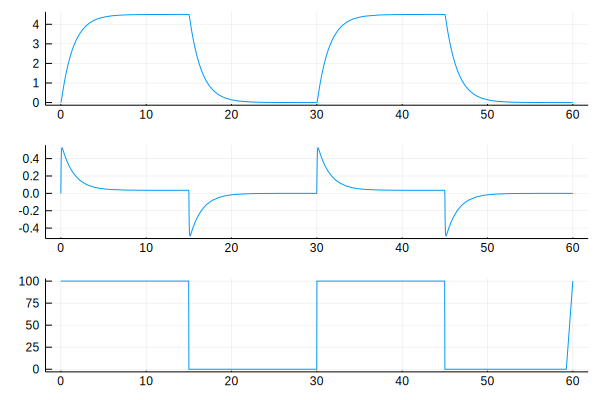

In [51]:
m = SystemModel(V_A_min=0, V_A_max=5, n=10, m=8, Vs=24, alpha_i=5/37.5, L=0.2, K_tau=7.2e-2, J_M=0.11e-3, J_I=1.3e-3, D=6.0e-5, K_e=7.16e-2, R=5.7, alpha_T=1.5/1000)
sol = @simulate(m, tspan = (0.0, 60.0), scope=[v_N, v_i, u_P])
sol.graph

In [52]:
@model Circuit begin
    @parameter
    
    @blk In = InBlock()
    @blk Saturation = SaturationBlock(upperlimit=5, lowerlimit=0)
    @blk Out = OutBlock()
    
    @connect In => Saturation
    @connect Saturation => Out
end

Circuit (generic function with 1 method)

In [53]:
@model PlantModel_new begin
    @parameter Vs
    @parameter alpha_i
    @parameter L K_tau J_M J_I D K_e R
    @parameter alpha_T
    
    @blk In = InBlock()
    @blk Constant = ConstantBlock(Vs)
    @blk MD = MotorDriver(alpha_i=alpha_i) inport[1]:in1 inport[2]:in2 inport[3]:in3 outport[1]:v_A outport[2]:v_i
    @blk DCMD = DCMotorDisk(L=L, K_tau=K_tau, J_M=J_M, J_I=J_I, D=D, K_e=K_e, R=R) outport[1]:omega outport[2]:i_M
    @blk T = Tachogenerator(alpha_T=alpha_T) outport:v_N
    @blk C = Circuit()
    @blk Out1 = OutBlock()
    @blk Out2 = OutBlock()
    
    @connect Constant => in1
    @connect In => in2
    @connect i_M => in3
    @connect v_A => DCMD
    @connect v_i => C
    @connect C => Out2
    @connect omega => T
    @connect v_N => Out1
end

PlantModel_new (generic function with 1 method)

In [54]:
@model SystemModel_new begin
    @parameter V_A_min V_A_max n m
    @parameter Vs
    @parameter alpha_i
    @parameter L K_tau J_M J_I D K_e R
    @parameter alpha_T
    
    @blk CM = ControllerModel(V_A_min=V_A_min, V_A_max=V_A_max, n=n, m=m) inport[1]:in1 inport[2]:in2 outport:u_P
    @blk PM = PlantModel_new(Vs=Vs, alpha_i=alpha_i, L=L, K_tau=K_tau, J_M=J_M, J_I=J_I, D=D, K_e=K_e, R=R, alpha_T=alpha_T) outport[1]:v_N outport[2]:v_i
    
    @connect v_N => in1
    @connect v_i => in2
    @connect u_P => PM
end

SystemModel_new (generic function with 1 method)

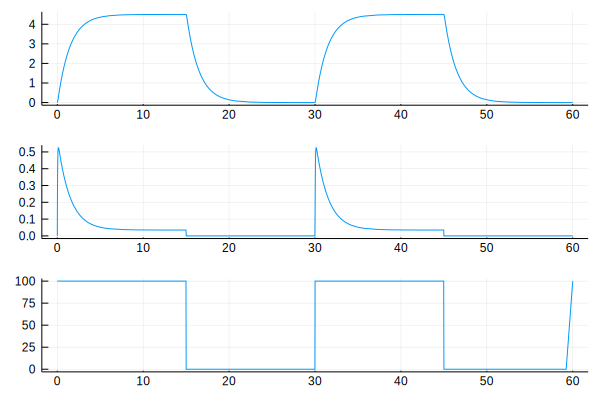

In [55]:
m = SystemModel_new(V_A_min=0, V_A_max=5, n=10, m=8, Vs=24, alpha_i=5/37.5, L=0.2, K_tau=7.2e-2, J_M=0.11e-3, J_I=1.3e-3, D=6.0e-5, K_e=7.16e-2, R=5.7, alpha_T=1.5/1000)
sol = @simulate(m, tspan = (0.0, 60.0), scope=[v_N, v_i, u_P])
sol.graph